<a href="https://colab.research.google.com/github/IsuruMahakumara/MovieRecommender/blob/Test/Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from os import listdir
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
import seaborn as sns
import time


In [ ]:
dir = '/content/drive/MyDrive/Daraz-Assigment/unzipped/'

file_list = listdir(dir)

file_list.remove('readme.txt')  #13 Data Files

In [ ]:
movie_countries = pd.read_csv(dir+'movie_countries.dat', sep='\t', encoding='cp1252') 

movie_directors = pd.read_csv(dir+'movie_directors.dat', sep='\t', encoding='cp1252') 

movie_genres = pd.read_csv(dir+'movie_genres.dat', sep='\t', encoding='cp1252') 

movie_tags = pd.read_csv(dir+'movie_tags.dat', sep='\t', encoding='cp1252') 

tags = pd.read_csv(dir+'tags.dat', sep='\t', encoding='cp1252') 

movie_locations = pd.read_csv(dir+'movie_locations.dat', sep='\t', encoding='cp1252') 

movies = pd.read_csv(dir+'movies.dat', sep='\t', encoding='cp1252') 

user_taggedmovies_timestamps = pd.read_csv(dir+'user_taggedmovies-timestamps.dat', sep='\t', encoding='cp1252') 

user_taggedmovies = pd.read_csv(dir+'user_taggedmovies.dat', sep='\t', encoding='cp1252') 

user_ratedmovies_timestamps = pd.read_csv(dir+'user_ratedmovies-timestamps.dat', sep='\t', encoding='cp1252') 

user_ratedmovies = pd.read_csv(dir+'user_ratedmovies.dat', sep='\t', encoding='cp1252') 

movie_actors = pd.read_csv(dir+'movie_actors.dat', sep='\t', encoding='cp1252') 

In [ ]:
#Wrangling movies.dat

movies_noisy_col =['imdbID', 'spanishTitle', 'imdbPictureURL', 'rtID', 'rtPictureURL']  # 
movies_rating_col = ['rtAllCriticsRating','rtAllCriticsNumReviews', 'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore','rtTopCriticsRating',
       'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh','rtTopCriticsNumRotten', 'rtTopCriticsScore','rtAudienceRating',
       'rtAudienceNumRatings', 'rtAudienceScore']


#Converting object to float
for col in movies_rating_col:
  movies[col] = pd.to_numeric(movies[col], errors='coerce')

#Compute mean rating 
movies["Mean Rating"] = movies[movies_rating_col].mean(axis=1)

#Min-Max Normalize the mean Rating
from sklearn.preprocessing import MinMaxScaler
x =movies["Mean Rating"].values.reshape(10197,1)
rating_scaled = MinMaxScaler().fit_transform(x)
movies["Mean Rating"] = rating_scaled


#Removing noisy columns
movies = movies.drop(columns=movies_noisy_col)
movies = movies.drop(columns=movies_rating_col)

#Rename id to moiveID for consistency
movies.rename(columns={'id':'movieID'}, inplace=True) 



In [ ]:
#movie directors.dat    movies_countries.dat


movie_directors.drop(['directorName'], axis=1, inplace=True)
movies  = movies.merge(movie_directors,on='movieID')



##Wrangling movie_actors.dat
movie_actors.drop(['actorName'], axis=1, inplace=True)
#Selecting the top two actors
movie_actors = movie_actors.loc[movie_actors['ranking']<3]
#Return top two actors into one field
movie_actors['actorID'] = movie_actors['actorID'] + "  "
actors = movie_actors.groupby('movieID')["actorID"].sum()
movie_actors = pd.DataFrame(actors)

#Merge with movies
movies = movies.merge(movie_actors, on = 'movieID')




#Wrangling movie_genres.dat
#Returning genres to one field
movie_genres['genre'] = movie_genres['genre'] +" "
genres = movie_genres.groupby(['movieID'])['genre'].sum()
genres = pd.DataFrame(genres)
#Mergin with movies
movies = movies.merge(genres, on='movieID')

movies.drop(columns=['Mean Rating'], inplace=True)


movies.tail()


before director  merge (10197, 4)
before actor merge (10155, 5)
before genre merge (10134, 6)


,movieID,title,year,directorID,actorID,genre
10129,65088,Bedtime Stories,2008,adam_shankman,adam_sandler keri_russell,Adventure Children Comedy
10130,65091,Manhattan Melodrama,1934,ws_van_dyke,clark_gable william_powell,Crime Drama Romance
10131,65126,Choke,2008,clark_gregg,anjelicahuston sam_rockwell,Comedy Drama
10132,65130,Revolutionary Road,2008,sam_mendes,kate_winslet leonardo_di_caprio,Drama Romance
10133,65133,Blackadder Back & Forth,1999,paul_weiland,colin_firth hugh_laurie,Comedy


In [ ]:
movies['year'] = movies['year'].astype('str')

movies ['Key'] = movies['directorID']+' '+movies['actorID']+' '+movies['genre']+' '+movies['year']
movies[['year', 'title', 'Key']].head()


,year,title,Key
0,1995,Toy story,john_lasseter tim_allen tom_hanks Adventure...
1,1995,Jumanji,joe_johnston bonnie_hunt robin_williams Adv...
2,1993,Grumpy Old Men,donald_petrie jack_lemmon walter_matthau Co...
3,1995,Waiting to Exhale,forest_whitaker angela_bassett whitney_housto...
4,1995,Father of the Bride Part II,charles_shyer diane_keaton steve_martin Com...


In [115]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_csr = cv.fit_transform(movies['Key'])
cosine_sim = cosine_similarity(X_csr)

In [117]:
##Cosine similarity

UserID=75
No_of_Similar_movies = 13

similar_movies = list(enumerate(cosine_sim[UserID]))
similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]
top = similar_movies[0:No_of_Similar_movies]

rec = pd.DataFrame(top, columns=['movieIndex', 'Similarity'])   
movies[['title','year','genre']].iloc[rec.movieIndex.values]

,title,year,genre
96,Heidi Fleiss: Hollywood Madam,1995,Documentary
111,Anne Frank Remembered,1995,Documentary
122,Jupiter's Wife,1995,Documentary
127,Sonic Outlaws,1995,Documentary
555,The Celluloid Closet,1995,Documentary
673,The Haunted World of Edward D. Wood Jr.,1995,Documentary
701,Carmen Miranda: Bananas Is My Business,1995,Documentary
4525,Titanica,1995,Documentary IMAX
36,Across the Sea of Time,1995,Documentary IMAX
129,From the Journals of Jean Seberg,1995,Documentary


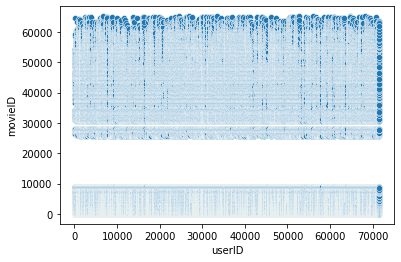

In [43]:
rating =  user_ratedmovies_timestamps.pivot(index='userID',columns='movieID',values='rating')
rating.fillna(0,inplace=True)
sns.scatterplot(x=user_ratedmovies_timestamps['userID'], y=user_ratedmovies_timestamps['movieID'])

In [ ]:
#Prediction Of Rating Using Singular Value Decomposition 
R = rating.values
R_mean = np.mean(R, axis = 1).reshape(-1,1)
R_demeaned = R - R_mean


from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
sigma = np.diag(sigma)
predicted_R = np.dot(np.dot(U, sigma), Vt) + R_mean
predicted_R = pd.DataFrame(predicted_R, index=rating.index, columns=rating.columns)

In [ ]:
predicted_R.head()

movieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,64288,64338,64368,64418,64427,64497,64499,64501,64508,64519,64575,64611,64614,64620,64622,64701,64716,64750,64839,64900,64921,64930,64942,64957,64969,64976,64983,64986,64990,64993,64997,64999,65006,65011,65037,65088,65091,65126,65130,65133
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
75,0.085647,0.213415,0.110423,0.016728,-0.049234,0.395392,0.097255,0.073124,0.081229,0.359853,0.038552,0.014774,-0.024591,-0.053770,0.195793,-0.053605,-0.121858,0.124504,0.306655,0.151700,0.259054,0.206089,0.172981,0.154814,0.026207,0.013550,0.023897,0.006386,0.121182,-0.019684,0.177445,1.274199,-0.022925,-0.030482,0.033625,-0.035037,-0.014534,-0.007550,0.190810,-0.026180,...,-0.001765,-0.021317,-0.002402,-0.001999,-0.006599,0.021309,-0.001289,-0.001289,-0.002557,-0.000587,-0.007421,-0.011214,0.020006,-0.031235,-0.007042,-0.012060,-0.001200,-0.000744,0.016119,-0.006289,0.007384,0.011616,0.008861,-0.029489,-0.015376,-0.001667,0.016459,-0.002397,-0.002626,-0.002388,-0.002469,-0.003598,-0.002559,0.000027,-0.006142,-0.002608,0.000200,0.003159,-0.007042,0.001275
78,2.370667,0.294171,-0.675386,-0.081445,-0.566633,0.252062,-0.584425,-0.036364,-0.127027,-0.171480,-0.168931,0.085331,-0.153159,0.197846,-0.316747,-0.945505,1.299495,0.097654,0.095394,-0.154912,0.947293,-0.597635,-0.102398,0.723485,1.348410,0.277287,-0.063238,0.476035,3.471630,0.365461,-0.401956,3.907163,0.111295,2.427650,0.346551,0.275876,0.134019,0.024014,0.488610,0.230131,...,0.005969,-0.067208,0.008639,0.010597,-0.006187,0.114660,-0.102203,-0.102203,0.008792,-0.032175,-0.231791,0.004906,-0.086456,-0.062500,-0.002353,-0.036883,0.096158,0.013989,-0.143011,-0.020378,-0.053538,-0.107710,-0.062166,-0.187843,0.018198,0.028565,0.010400,0.023051,-0.008606,0.010098,-0.042680,0.007120,0.032698,0.009389,0.017942,0.029469,-0.045188,0.027863,-0.002353,0.039496
127,0.010428,0.047469,0.015976,0.004490,0.068292,-0.037154,0.001788,0.001419,-0.006662,-0.058778,-0.009956,0.023881,0.026996,0.024362,0.002202,-0.057802,0.122176,-0.056001,0.036713,0.029126,-0.063585,0.043932,0.022685,0.039762,-0.007609,-0.018548,0.037206,0.022532,-0.049512,0.002357,0.009844,-0.004728,0.009896,0.078640,0.011698,0.011591,-0.002451,0.000041,0.066799,0.005298,...,0.001972,-0.008279,0.003431,0.002493,0.002812,0.012743,-0.008046,-0.008046,0.000116,0.001596,-0.012457,0.005838,0.004836,0.004085,0.000879,-0.002518,0.017713,0.002762,0.000496,0.001248,-0.000321,0.000129,-0.000516,-0.018971,0.005402,0.001285,-0.001128,0.003483,-0.008613,0.002695,-0.000904,0.001098,0.002294,-0.001312,0.001491,0.002138,0.001780,0.003912,0.000879,-0.001528
170,1.181997,0.766787,0.264725,0.046024,0.029374,0.315996,-0.090060,-0.027110,-0.070596,0.705608,0.085629,0.005131,0.059259,0.066592,-0.042068,0.521412,-0.424080,0.155409,1.091076,0.048542,0.561407,-0.104832,0.048383,0.112091,0.340512,0.001649,-0.012380,-0.100799,-0.018579,-0.014147,0.206019,1.945575,0.013093,0.499165,0.007824,0.064715,0.024850,0.001677,0.828667,0.012777,...,-0.006017,-0.021200,-0.014561,-0.007627,-0.019438,-0.016909,-0.018677,-0.018677,-0.021211,-0.001580,-0.036981,0.004470,-0.020394,-0.026147,-0.009939,-0.012916,-0.003225,-0.001850,-0.026852,-0.012333,0.006220,0.009275,0.007546,-0.035591,0.020865,-0.002031,0.016298,0.000003,0.006471,0.004762,-0.007663,-0.003119,-0.009331,-0.006964,0.001690,-0.008547,-0.001086,0.000242,-0.009939,0.017452
175,3.224798,0.821154,0.232838,0.004666,0.196803,1.768103,0.220659,0.078117,-0.086389,1.418806,0.434296,-0.194475,0.212802,-0.013824,-0.203703,1.084188,1.394023,0.089928,0.730022,-0.004211,0.939800,-0.142645,0.257184,0.213560,1.849690,0.286122,0.017637,0.170962,1.768203,0.233700,0.260797,4.604725,0.009194,1.673548,0.068539,1.690044,0.005099,0.039511,1.398676,0.214612,...,-0.013732,-0.078108,-0.010209,-0.023280,-0.017555,0.098960,-0.030755,-0.030755,-0.020708,-0.036564,-0.100135,-0.021545,0.0295

In [ ]:


def get_index(title):
    item = movies[movies.title == title]["index"].values[0]
    return print(item)


def get_title(movieID):
  title = movies['title'].loc[movies['movieID']==movieID].values[0]
  return title
    


In [ ]:
recom_ID = movies.iloc[recom_Index]['movieID'].values


predicted_R.describe()



movieID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,64288,64338,64368,64418,64427,64497,64499,64501,64508,64519,64575,64611,64614,64620,64622,64701,64716,64750,64839,64900,64921,64930,64942,64957,64969,64976,64983,64986,64990,64993,64997,64999,65006,65011,65037,65088,65091,65126,65130,65133
count,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,...,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000,2113.000000
mean,2.219115,1.086747,0.335853,0.056308,0.303894,1.087590,0.403251,0.051204,0.071068,1.164713,0.602438,0.110479,0.041831,0.128881,0.143479,0.946367,0.669238,0.324624,0.855519,0.159239,0.810564,0.370723,0.198463,0.306226,0.766281,0.118363,0.072214,0.129953,0.624361,0.031044,0.350674,2.217640,0.005939,1.227869,0.044974,0.780756,0.007246,0.018176,1.005122,0.024864,...,0.001014,0.006206,0.001790,0.002292,0.001856,0.033354,0.003500,0.003500,0.005951,0.001580,0.017082,0.002271,0.028474,0.028004,0.001139,0.004353,0.031612,0.000977,0.018770,0.002276,0.002463,0.004348,0.002781,0.049119,0.008396,0.000479,0.010032,0.001247,0.003686,0.002174,0.006783,0.000331,0.002278,0.002633,0.002788,0.002023,0.002028,0.003026,0.001139,0.005479
std,1.502008,1.023272,0.570608,0.180592,0.526253,1.279940,0.702829,0.212315,0.223776,1.213208,0.922594,0.294944,0.184864,0.364936,0.370019,1.183289,0.991633,0.540485,0.931496,0.348503,1.003349,0.690452,0.460055,0.531409,1.019266,0.248103,0.291252,0.402429,0.961394,0.120620,0.577627,1.521488,0.046368,1.159373,0.206389,1.018466,0.049357,0.094511,1.095467,0.095274,...,0.018269,0.063731,0.023150,0.019965,0.026042,0.120326,0.052410,0.052410,0.029104,0.033527,0.111946,0.034785,0.113257,0.132676,0.019885,0.037047,0.102600,0.018419,0.113137,0.026476,0.069721,0.087144,0.079120,0.173360,0.041315,0.021154,0.090778,0.019164,0.049756,0.019880,0.049655,0.017113,0.025553,0.030610,0.024229,0.023835,0.042094,0.029303,0.019885,0.042039
min,-0.906743,-0.912549,-1.041768,-0.489217,-1.382469,-2.030467,-1.294116,-0.543997,-0.555904,-0.977989,-1.089476,-0.698345,-0.516866,-0.934190,-0.912721,-1.418911,-2.017669,-1.293737,-1.123003,-0.567353,-0.902991,-1.276876,-1.020814,-0.730301,-1.216148,-0.907797,-0.832555,-0.891580,-1.469476,-0.536203,-1.728946,-1.220103,-0.203629,-0.887723,-0.853028,-1.310553,-0.206808,-0.255709,-1.298318,-0.281440,...,-0.100837,-0.220795,-0.085167,-0.095522,-0.163825,-0.517728,-0.253767,-0.253767,-0.145856,-0.112071,-0.387076,-0.160519,-0.390918,-0.574324,-0.126222,-0.161075,-0.389302,-0.108760,-0.413784,-0.168405,-0.167515,-0.195413,-0.179040,-0.584179,-0.195575,-0.117433,-0.374442,-0.105381,-0.282265,-0.111669,-0.203539,-0.109297,-0.138716,-0.186248,-0.096821,-0.126362,-0.133306,-0.164852,-0.126222,-0.255319
25%,0.934773,0.229846,-0.006756,-0.019191,-0.003861,0.126527,-0.010289,-0.036779,-0.031060,0.197364,0.017301,-0.030516,-0.040617,-0.033826,-0.039390,0.056552,0.059235,0.004011,0.129576,-0.011962,0.075675,-0.000954,-0.011938,0.010571,0.036321,-0.002864,-0.042265,-0.048206,-0.009476,-0.027079,0.018057,0.924748,-0.015512,0.284472,-0.041042,0.067816,-0.014777,-0.019692,0.169815,-0.019728,...,-0.006214,-

In [ ]:
User_ratedMovies = rating.iloc[75].apply(lambda x:x!=0)
watched = User_ratedMovies[User_ratedMovies].index.values.reshape(1,-1)

User_ratedMovies.head()

movieID
1    False
2    False
3    False
4    False
5    False
Name: 2477, dtype: bool

In [103]:
#Select the 05 most recent and highest rated movies of UserID
User_ratedMovies = rating.iloc[75].apply(lambda x:x>4)
sample = User_ratedMovies[User_ratedMovies]#.index.values
#sample = np.random.choice(sample, 5)
sample_index = movies.loc[movies['movieID'].isin(sample)].index.values





In [109]:
User_ratedMovies = rating.iloc[175].sort_values(ascending=False)[0:10]#.apply(lambda x:x>4) ## Movies with rating>4

User_ratedMovies.index.values

array([ 1039,  4136,   404,   769, 31410, 33603,  8973,  3062,  3967,
        5952])

In [112]:
##API returning movies 


def Recommendations(UserID, N_recommendations):

##Select movieIds of  #(N_recommendations)  samples of  highest rated movies seen by  UserID 
  sample = rating.iloc[UserID].sort_values(ascending=False)[0:N_recommendations].index.values 
  
  #Select indices of the movieIDs
  sample_index = movies.loc[movies['movieID'].isin(sample)].index.values ## indices as in movies dataframe NOT movieID
  print("size of sample: ", sample.shape[0])

  

##Recommending Similar Movies via Cosine Similarity  
  recom_Index = np.zeros(N_recommendations, dtype=int) ## to Store indices of the recommended movies
  
  #Selecting the most similar movie for each sample movie
  for i in range(N_recommendations):
    similar_movies = cosine_sim[sample_index[i]].reshape(-1,1)
    similar_movies = pd.DataFrame(similar_movies, columns=['Similarity']).sort_values(by =['Similarity'], ascending=False)[1:2].index.values
    recom_Index [i]= similar_movies

  #Returning Corresponding movieID
  recom_ID = movies.iloc[recom_Index]


 

  return recom_ID[['movieID',	'title',	'year', 'genre'	]]


In [114]:
#Cos_recom = Recommendations(127,10)['movieID'].values
Recommendations(170,10)

size of sample:  10


,movieID,title,year,genre
7995,25934,The Godfather,1972,Drama Western
5097,5459,Men in Black II,2002,Action Comedy Sci-Fi
2786,3040,Meatballs,1979,Comedy
1654,1869,Black Dog,1998,Action Thriller
2347,2581,Never Been Kissed,1999,Comedy Romance
2558,2804,A Christmas Story,1983,Children Comedy
9918,61132,Tropic Thunder,2008,Action Adventure Comedy War
4409,4746,Waking Up in Reno,2002,Comedy Romance
5056,5416,Cherish,2002,Comedy Drama Thriller
6990,7458,Troy,2004,Action Adventure Drama War


In [61]:
#Evaluations

recom_ID = Recommendations(75,10)['movieID'].values

def Precision(recom_ID, UserID):


#MinMax Scaling
  min = predicted_R.iloc[UserID].describe()[3]
  max =  predicted_R.iloc[UserID].describe()[7]

  Rating_for_UserId = predicted_R[recom_ID].iloc[UserID].to_frame(name='Unscaled')
  Rating_for_UserId['Scaled'] = (Rating_for_UserId['Unscaled'] - min)/(max-min)

  Pred_for_UserId = Rating_for_UserId.loc[Rating_for_UserId['Scaled'] >0.5 ].index.values

#hits = np.isin(Cos_recom, Pred_for_UserId).sum()

  Rating_for_UserId
  precision = hits/10
  return precision




0.1

In [67]:
UserID = 170

recom_ID = Recommendations(UserID,10)['movieID'].values
Precision(recom_ID, UserID)

0.1